In [1]:
import numpy as np
import pickle
import os
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
# Define the root directory
name = 'Dataset-ppi--RE-True--W-True--Epochs-15000--D-4--RH-25--LR-0.1--LP-False--CUDA-True'
root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'+name
# W = True

# load data

## get hierarchical structure of level 1

In [3]:

# Specify the variable names
# variable_names = ['k_exp_dist','final_idx', 'general_cl_id', 'general_mask']
variable_names = ['k_exp_dist', 'general_cl_id', 'general_mask']
# Initialize a dictionary to store the loaded variables
loaded_variables = {}

# Loop through the variable names and load the data from pickle files
for var_name in variable_names:
    file_path = os.path.join(root, var_name + '.pkl')
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    loaded_variables[var_name] = loaded_data

# Access the loaded variables as needed
k_exp_dist = loaded_variables['k_exp_dist']
# final_idx = loaded_variables['final_idx']
general_cl_id = loaded_variables['general_cl_id']
general_mask = loaded_variables['general_mask']

### check data structure

In [4]:
k_exp_dist = np.array(k_exp_dist)
k_exp_dist.shape

(2074, 2074)

In [5]:
# check the cluster ids in different levels
for i in general_cl_id:
    a = list(set(i))
    print(a[0],a[-1])
    print(len(list(set(i))))

0 9
10
10 29
20
30 69
40
70 149
80
150 299
150
512 511
258
558 1003
446
1004 1533
530
1534 1909
376
1910 2037
128
2048 2047
28
2066 2073
8


In [6]:
# check nodes in different levels, the position is map to general_cl_id cluster ids
for i in general_mask:
    a = list(set(i))
    print(max(a),min(a))

18766 0
18766 0
18766 0
18766 0
18766 0
18766 0
18766 0
18766 0
18766 0
18761 0
18692 71
18692 71


### take level 1 nodes

In [7]:
level = 0

In [8]:
# check if the mask is ordered
if general_mask[level].tolist() != sorted(general_mask[level].tolist()):
    print('False')

In [9]:
# since the general_mask[0] is ordered, we can directly use list index as the node id
L1 = general_cl_id[level]
unique_values = np.unique(L1)
index_dict = {value: np.where(L1 == value)[0].tolist() for value in unique_values}

In [10]:
for key, value in index_dict.items():
    print(f"Key: {key}, Value Length: {len(value)}")

Key: 0, Value Length: 1875
Key: 1, Value Length: 1254
Key: 2, Value Length: 1595
Key: 3, Value Length: 2001
Key: 4, Value Length: 1853
Key: 5, Value Length: 2542
Key: 6, Value Length: 2150
Key: 7, Value Length: 826
Key: 8, Value Length: 2850
Key: 9, Value Length: 1821


In [11]:
max(index_dict.keys())

9

### hierarchical structure of level 1

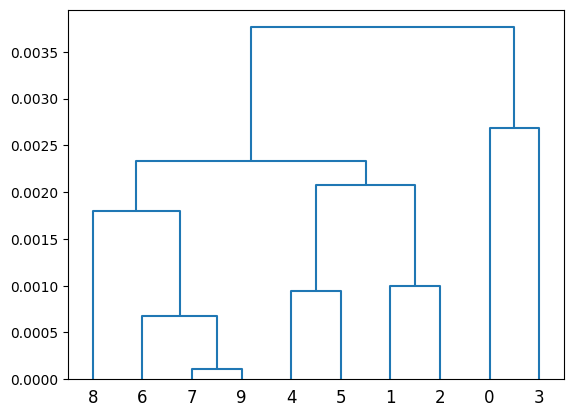

In [12]:

pltroot = 'D:/study/thesis/project/HBDM-main/ppi_results/plots/'

# Create your matrix of within-cluster Euclidean distances
distance_matrix = k_exp_dist[:10,:10]
# distance_matrix = k_exp_dist[30:70,30:70]
# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='average')
dendrogram = sch.dendrogram(linkage_matrix, color_threshold=0)

# plt.title('Post-Processing Agglomerative Clustering Dendrogram')
# plt.xlabel('Clusters')
# plt.ylabel('Euclidean Distance')
# plt.savefig(pltroot+'Dendrogram-'+name+'.png')
# plt.show()

order = dendrogram['leaves']

In [462]:
len(order)

40

### get node order

In [13]:
# order = [int(x) + 30 for x in order]
index = []
for key in order:
    index.extend(index_dict[key])

In [14]:
len(index)

18767

## latent representation

In [465]:
### get node and 1d,2d

file_path_d = 'D:/study/thesis/project/HBDM-main/ppi_results/latent/'+name +'.pkl'
with open(file_path_d, 'rb') as file:
    loaded_tensor = pickle.load(file)

tensor = loaded_tensor.cpu()
node_rep = tensor.detach().numpy()


df_latent = pd.DataFrame()
for d in range(node_rep.shape[1]):
    col_name = str(d+1)+'d'
    df_latent[col_name] = node_rep.T[d]
df_latent['node'] = df_latent.index

In [466]:
## get node and cluster
clusters = []
ori_index = []
for key in index_dict:
    clusters += len(index_dict[key])*[int(key)]
    ori_index.extend(index_dict[key])
df = pd.DataFrame({'node': ori_index, 'cluster': clusters})

In [467]:
## get df: node, cluster, 1d, 2d
df = df.merge(df_latent)
df = df.sort_values(by='node')
df.head(5)

,node,cluster,1d,2d,3d,4d
7221,0,47,-1.582698,0.707539,1.583527,-4.250939
7222,1,47,-0.648328,1.125334,-0.895714,-3.879148
16054,2,65,-0.189585,2.141957,-2.028791,-0.886637
2395,3,35,-2.142985,-5.395441,-5.077823,-0.483894
17704,4,68,-4.122100,-1.389301,1.544466,0.875275


# Visualization

## read original adjacency matrix

In [15]:
# if W is True:
#     sparse_i = []
#     sparse_j = []
#     for level in range(1,10):
#         inputfile = 'D:/study/thesis/project/HBDM-main/datasets/ppi/level_'+str(level)
#         sparse_i_level=np.loadtxt(inputfile+'_sparse_i.txt').astype(int)
#         # input data, link column positions with i<j
#         sparse_j_level=np.loadtxt(inputfile+'_sparse_j.txt').astype(int)
#         sparse_i.extend(sparse_i_level)
#         sparse_j.extend(sparse_j_level)
# else:
#     path1=r'D:\study\thesis\project\HBDM-main\datasets\ppi\sparse_i.txt'
#     path2=r'D:\study\thesis\project\HBDM-main\datasets\ppi\sparse_j.txt'
#     # Step 1: Read data from sparse_i and sparse_j files
#     sparse_i = np.loadtxt(path1)
#     sparse_j = np.loadtxt(path2)
#     sparse_i = sparse_i.astype(int)
#     sparse_j = sparse_j.astype(int)

path1=r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\sparse_i.txt'
path2=r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\sparse_j.txt'
# Step 1: Read data from sparse_i and sparse_j files
sparse_i = np.loadtxt(path1)
sparse_j = np.loadtxt(path2)
sparse_i = sparse_i.astype(int)
sparse_j = sparse_j.astype(int)


In [ ]:
# ## ad 
# ad = coo_array((57508*[1], (np.concatenate((sparse_i, sparse_j)), np.concatenate((sparse_j, sparse_i)))), shape=(20111, 20111)).toarray()

In [16]:
## G
G = nx.Graph()
edges = zip(sparse_i, sparse_j)
G.add_edges_from(edges)

In [471]:
len(sparse_i)

805326

In [17]:
len(G.nodes)

18767

## adjacency matrix visualization: original vs ordered

C:\Users\ZZY\AppData\Local\Temp\ipykernel_33316\710690624.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adjacency_matrix = nx.to_numpy_array(G, dtype=np.bool)


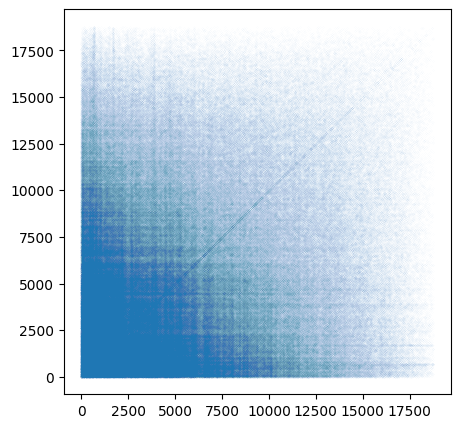

In [472]:
adjacency_matrix = nx.to_numpy_array(G, dtype=np.bool)
coords = np.argwhere(adjacency_matrix==True)
fig = plt.figure(figsize=(5, 5))
plt.scatter(coords[:,1],coords[:,0],s=0.00005)
# plt.savefig(pltroot+name+'.png')
plt.show()


C:\Users\ZZY\AppData\Local\Temp\ipykernel_52556\1408844357.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ad = nx.to_numpy_array(G, dtype=np.bool, nodelist=index)


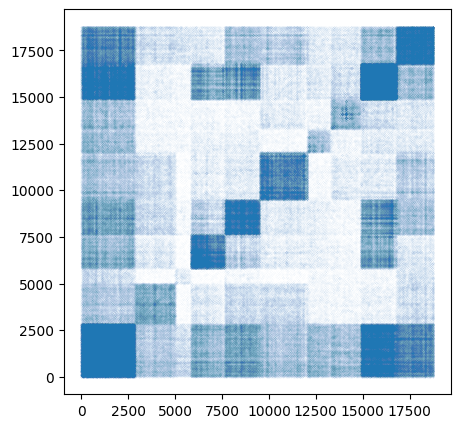

In [18]:
ad = nx.to_numpy_array(G, dtype=np.bool, nodelist=index)
coords = np.argwhere(ad==True)
fig = plt.figure(figsize=(5, 5))
plt.scatter(coords[:,1],coords[:,0],s=0.00005)
plt.savefig(pltroot+'ordered-'+name+'.png')
plt.show()

C:\Users\ZZY\AppData\Local\Temp\ipykernel_33316\3469130575.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ad = nx.to_numpy_array(G, dtype=np.bool, nodelist=order)


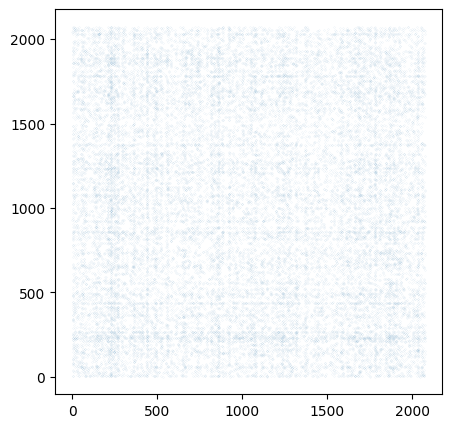

In [ ]:
ad = nx.to_numpy_array(G, dtype=np.bool, nodelist=order)
coords = np.argwhere(ad==True)
fig = plt.figure(figsize=(5, 5))
plt.scatter(coords[:,1],coords[:,0],s=0.001)
plt.savefig(pltroot+'ordered-'+name+'.png')
plt.show()

## cluster zoom

In [ ]:
def show_cluster(df):
    colors = plt.cm.Paired(np.linspace(0, 1, 10))  # You can choose a different colormap if you prefer

    # Create a color map dictionary
    color_map = {i: colors[i] for i in range(10)}

    # Create a scatter plot
    plt.scatter(df['1d'], df['2d'], c=df['cluster'].map(color_map), cmap='Paired',s=0.1)

    # Add labels and a legend
    plt.xlabel('1d')
    plt.ylabel('2d')

    # Create a legend with labels based on unique clusters
    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=cluster, 
                                markerfacecolor=color_map[cluster], markersize=10) for cluster in df['cluster'].unique()]
    plt.legend(handles=legend_labels)
    plt.savefig(pltroot+'cluster-'+name+'.png')
    # Show the plot
    plt.show()


In [ ]:
# %matplotlib widget
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# # creating figure
# colors = plt.cm.Paired(np.linspace(0, 1, 10))  # You can choose a different colormap if you prefer

# # Create a color map dictionary
# color_map = {i: colors[i] for i in range(10)}

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # creating the plot
# plot_geeks = ax.scatter(df['1d'], df['2d'], df['3d'], c=df['cluster'].map(color_map), cmap='Paired',s=0.1)

# # setting title and labels
# ax.set_title("3D plot")
# ax.set_xlabel('x-axis')
# ax.set_ylabel('y-axis')
# ax.set_zlabel('z-axis')

# # Create a legend with labels based on unique clusters
# legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=cluster, 
#                             markerfacecolor=color_map[cluster], markersize=10) for cluster in df['cluster'].unique()]
# plt.legend(handles=legend_labels)

# # displaying the plot
# plt.show()

In [ ]:
# subdf = df[(df['1d'] > -20) & (df['1d'] < 20) & (df['2d'] > -20) & (df['2d'] < 20)]
# show_cluster(subdf)

In [ ]:

# #Plot adjacency matrix in toned-down black and white
# fig = plt.figure(figsize=(5, 5)) # in inches
# plt.imshow(ad,
#                 cmap="Greys",
#                 interpolation='none')

# Test

## choose test dataset

In [ ]:
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_index.pkl', 'rb') as f:
    value_to_index_mapping = pickle.load(f)
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_aliases2stringId.pkl', 'rb') as f:
    ppi_name2stringId = pickle.load(f)
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_name2stringId.pkl', 'rb') as file:
    name2stringId = pickle.load(file)
def convert_stringId(alias):
    try:
        stringId = name2stringId[alias]
    except:
        #print(alias, 'can\'t be converted by name2stringId! Now trying aliases2stringId.')
        try:
            stringId = ppi_name2stringId[alias]
        except:
            #print(alias, 'can\'t be converted by aliases2stringId! Now return None.')
            stringId = None
    #print(alias, stringId)
    return stringId

### from STRING-KEGG

In [ ]:
# test_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\disease\CAD\KEGG Lipid and atherosclerosis.tsv',sep='\t')
# group = set(test_df['#node1'].unique())
# group.update(set(test_df['node2'].unique()))
# group = list(group)

# group_node = []
# for gene in group:
#     stringid = ppi_name2stringId[gene]
#     node = value_to_index_mapping[int(stringid[9:])]
#     group_node.append(node)

### from STRING cluster

In [ ]:
# string_15942=pd.read_csv(r'D:\study\thesis\project\HBDM-main\string module\9606.clusters.proteins.v12.0.txt',sep='\t')
# string_15942 = string_15942[string_15942['cluster_id'] == 'CL:15942']
# group_node = []
# for i in string_15942['protein_id']:
#     node = value_to_index_mapping[int(i[9:])]
#     group_node.append(node)

## label df with given group_node

### check label position in latent space

In [ ]:
# group_df = df[df['node'].isin(group_node)]
# group_df['cluster'].unique()

In [ ]:
# ## get final df: node, cluster, 1d, 2d, label
# df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
# # Set the index to match the values in column 'node'
# df = df.set_index('node')
# # Reset the index to its default integer index
# df = df.reset_index()

In [ ]:
# # def show_positive(df):
# #     # Define the color map
# #     color_map = {0: 'grey', 1: 'red'}

# #     # Create a scatter plot
# #     plt.scatter(df['1d'], df['2d'], c=df['label'].map(color_map), s=0.1, label='Data Points')

# #     # Add labels
# #     plt.xlabel('1d')
# #     plt.ylabel('2d')


# #     # Set plot title
# #     plt.title('Scatter Plot of 1d vs. 2d')

# #     # Show the plot
# #     plt.grid(True)
# #     plt.savefig(pltroot+'positive-'+name+'.png')
# #     plt.show()

# %matplotlib widget

# # creating figure
# color_map = {0: 'grey', 1: 'red'}

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # creating the plot
# plot_geeks = ax.scatter(df['1d'], df['2d'], df['3d'], c=df['label'].map(color_map), s=0.1, label='Data Points')

# # setting title and labels
# ax.set_title("3D plot")
# ax.set_xlabel('x-axis')
# ax.set_ylabel('y-axis')
# ax.set_zlabel('z-axis')


# # displaying the plot
# plt.show()

In [ ]:
# show_positive(df[(df['1d'] > -20) & (df['1d'] < 20) & (df['2d'] > -20) & (df['2d'] < 20)])
# show_positive(df)

## k nearest neighbor method

In [ ]:
import random
from sklearn.neighbors import KDTree
from sklearn.model_selection import KFold

### for protein complex

In [ ]:
# human_all = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\complexes\9606.tsv',sep='\t')
protein_names = list(ppi_name2stringId.keys())
protein_names.extend(list(name2stringId.keys()))
# complexs = dict()
# for i in range(len(human_all)):
#     complex_name = human_all.iloc[i]['#Complex ac']
#     names = human_all.iloc[i]['Recommended name']
#     if ',' in names:
#         name_list = names.split(',')
#         for name in name_list:
#             if '-' in name:
#                 par_list = name.split('-')
#                 if len(par_list) > 1:
#                     if all(element in protein_names and len(element)>1 for element in par_list):
#                         # print(par_list)
#                         complexs[complex_name] = par_list
                            
#     elif '-' in names:
#         name = names.split(' ')[0]
#         par_list = name.split('-')
#         if len(par_list) > 1:
#             if all(element in protein_names and len(element)>1 for element in par_list):
#                 # print(par_list)
#                 complexs[complex_name] = par_list

with open(r'D:\study\thesis\project\HBDM-main\data\complexes\complexes.pkl', 'rb') as f:
    complexs = pickle.load(f)

In [ ]:
# complexs = {'RNA':['RPB1', 'RPB2', 'RPB3', 'RPB4', 'RPB5', 'RPB6', 'RPB7', 'RPB8', 'RPB9', 'RPB10', 'RPB11', 'RPB12', 'RPB13'],
#     'protease': ['PSMA1', 'PSMA2', 'PSMA3', 'PSMB1', 'PSMB2', 'PSMB3'],
#     'nuclear pore': ['NUP98', 'NUP93', 'NUP107', 'NUP133']
# }

humans = set(value_to_index_mapping.keys())

complexs_id = dict()

for complex_name in complexs:
    # folder_path = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/'+complex_name
    # os.mkdir(folder_path)
    group_node = []
    for gene in complexs[complex_name]:
        if gene in protein_names:
            stringid = convert_stringId(gene)
            stringid = int(stringid[9:])
            if stringid in humans:
                node = value_to_index_mapping[stringid]
                group_node.append(node)
    if len(set(group_node)) != 1:
        complexs_id[complex_name] = group_node

In [ ]:
complexs['CPX-2823']

['NUBP1', 'NUBP2']

In [ ]:
complexs_id['CPX-2823']

[3752, 2379]

In [ ]:
# Define your range of k values and leaf_size values
k_values = [20,50]
col1 = []
precision_col_20= []
precision_col_200= []
coverage_col_20=[]
coverage_col_200=[]

for complex_name in complexs_id:
    output_file = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/'+complex_name+'/'+name+".txt"
    group_node = complexs_id[complex_name]
    col1.append(complex_name)
    precision_list = []
    coverage_list = []

    ## get final df: node, cluster, 1d, 2d, label
    df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
    # Set the index to match the values in column 'node'
    df = df.set_index('node')
    # Reset the index to its default integer index
    df = df.reset_index()    
    # with open(output_file, "w") as f:
    for k in k_values:
        k+=1

        kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)

        precision = []
        coverage = []
        for i in group_node:
            true_pre = []
            test_nodes = list(set(group_node)-set([i]))
            given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
            # Perform a k-NN search to find the k+1 nearest neighbors
            distances, indices = kdtree.query(given_point, k=k)
            # start += (k-1)*[i]
            # dist += distances.reshape(-1).tolist()[1:]
            neighbor = indices.reshape(-1).tolist()[1:]

            for j in neighbor:
                if j in test_nodes:
                    true_pre.append(j)
            precision.append(len(true_pre)/len(neighbor))
            coverage.append(len(set(true_pre))/len(test_nodes))
        precision_list.append(sum(precision)/len(precision))
        coverage_list.append(sum(coverage)/len(coverage))
    precision_col_20.append(precision_list[0])
    precision_col_200.append(precision_list[1])
    coverage_col_20.append(coverage_list[0])
    coverage_col_200.append(coverage_list[1])
            # print(f'k- {k-1} precision: {sum(precision)/len(precision)} coverage: {sum(coverage)/len(coverage)}', file=f)
    # f.write()

In [ ]:
true_pre

[7500]

In [ ]:
result = pd.DataFrame({'complex': col1, 'precision_20':precision_col_20,'precision_50':precision_col_200,'coverage_20':coverage_col_20,'coverage_50':coverage_col_200})
results_name = name +'.csv'
result.to_csv('D:/study/thesis/project/HBDM-main/ppi_results/test_results/complexes/'+results_name,index=False)

### from DisGeNET disease

In [ ]:
# disease_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\disease\Achondroplasia.tsv',sep='\t')
# names = set(ppi_name2stringId.keys())
# humans = set(value_to_index_mapping.keys())

# group_node = []
# for gene in disease_df['Gene']:
#     if gene in names:
#         stringid = ppi_name2stringId[gene]
#         stringid = int(stringid[9:])
#         if stringid in humans:
#             node = value_to_index_mapping[stringid]
#             group_node.append(node)

# output_file = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/Achondroplasia/'+name+".txt"

In [ ]:
# # Define your range of k values and leaf_size values
# k_values = [2, 3, 4, 5, 6, 7, 8, 9]

# # Split your data into 5 folds
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# with open(output_file, "w") as f:
#     for k in k_values:
#         k+=1
#         precision_scores = []
#         coverage_scores = []
#         random_precision_scores = []
#         random_coverage_scores = []

#         # Build a k-d tree from the points
#         kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
#         for train_index, test_index in kf.split(group_node):
#             train_nodes = [group_node[i] for i in train_index]
#             test_nodes = [group_node[i] for i in test_index]

#             start = []
#             dist = []
#             neighbor = []
#             random_nodes = []
#             for i in train_nodes:
#                 given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
#                 # Perform a k-NN search to find the k+1 nearest neighbors
#                 distances, indices = kdtree.query(given_point, k=k)
#                 start += (k-1)*[i]
#                 dist += distances.reshape(-1).tolist()[1:]
#                 neighbor += indices.reshape(-1).tolist()[1:]

#                 random_nodes += random.sample(list(set(df['node'].tolist())-set(train_nodes)), (k-1))

#             neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
#             cover_df = neighbor_df[neighbor_df['neighbor'].isin(test_nodes)]
#             # if len(cover_df) == 0:
#             #     print(test_nodes)
#             # Append precision and coverage scores to lists
#             precision_scores.append(len(cover_df) / len(neighbor_df))
#             coverage_scores.append(len(cover_df['neighbor'].unique()) / len(test_nodes))
            
#             ############################ random
#             random_cover = []
#             for j in random_nodes:
#                 if j in test_nodes:
#                     random_cover.append(j)

#             random_precision_scores.append(len(random_cover)/ len(random_nodes))
#             random_coverage_scores.append(len(set(random_cover))/ len(test_nodes))

#         ###### choose one fold to check details
#         ranked = neighbor_df.sort_values(by='distance')
#         coverage = 0
#         for top_threshold in range(50, len(neighbor_df), 50):
#             cover = []
#             top_recommend = ranked['neighbor'].tolist()[:top_threshold]
#             for i in top_recommend: 
#                 if i in test_nodes:
#                     cover.append(i)
#             if len(set(cover)) / len(test_nodes) > coverage:
#                 coverage = len(set(cover)) / len(test_nodes)
#                 top_precision = len(cover) / top_threshold
#                 print(f'top {top_threshold} precision: {top_precision}', file=f)
#                 print(f'top {top_threshold} coverage: {coverage}', file=f)
#             else:
#                 print('coverage limitation', file=f)
#                 break
#         # Calculate the average precision and coverage scores for the current k and leaf_size
#         avg_precision = sum(precision_scores) / len(precision_scores)
#         avg_coverage = sum(coverage_scores) / len(coverage_scores)

#         random_avg_precision = sum(random_precision_scores) / len(random_precision_scores)
#         random_avg_coverage = sum(random_coverage_scores) / len(random_coverage_scores)
        
#         print(f"k={k-1}, leaf_size={20}",'\t',"Average Precision:", avg_precision,'\t',"Average Coverage:", avg_coverage)
#         result_line = f"k={k-1}, leaf_size={20}\tAverage Precision: {avg_precision}\tAverage Coverage: {avg_coverage}\n"
#         print(f"k={k-1}, leaf_size={20}\tRandom Precision: {random_avg_precision}\tRandom Coverage: {random_avg_coverage}", file=f)
#         f.write(result_line)


##### others

In [ ]:
# from sklearn.model_selection import KFold

# # Define your range of k values and leaf_size values
# k_values = [2,3,4,5,6,7,8,9]

# for complex_name in complexs_id:
#     output_file = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/'+complex_name+'/'+name+".txt"
#     group_node = complexs_id[complex_name]

#     ## get final df: node, cluster, 1d, 2d, label
#     df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
#     # Set the index to match the values in column 'node'
#     df = df.set_index('node')
#     # Reset the index to its default integer index
#     df = df.reset_index()    
#     # Split your data into 5 folds
#     with open(output_file, "w") as f:
#         for k in k_values:
#             k+=1
#             precision_scores = []
#             coverage_scores = []
#             random_precision_scores = []
#             random_coverage_scores = []

#             # Build a k-d tree from the points
#             kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
#             for liter in range(10):
#                 num_to_test = int(len(group_node) * 0.8)
#                 train_nodes = random.sample(group_node, num_to_test)
#                 test_nodes =  list(set(group_node) - set(train_nodes))

#                 start = []
#                 dist = []
#                 neighbor = []
#                 random_nodes = []
#                 for i in train_nodes:
#                     given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
#                     # Perform a k-NN search to find the k+1 nearest neighbors
#                     distances, indices = kdtree.query(given_point, k=k)
#                     start += (k-1)*[i]
#                     dist += distances.reshape(-1).tolist()[1:]
#                     neighbor += indices.reshape(-1).tolist()[1:]

#                     random_nodes += random.sample(list(set(df['node'].tolist())-set(train_nodes)), (k-1))

#                 neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
#                 cover_df = neighbor_df[neighbor_df['neighbor'].isin(test_nodes)]
                
#                 # Append precision and coverage scores to lists
#                 precision_scores.append(len(cover_df) / len(neighbor_df))
#                 coverage_scores.append(len(cover_df['neighbor'].unique()) / len(test_nodes))
                
#                 ############################ random
#                 random_cover = []
#                 for j in random_nodes:
#                     if j in test_nodes:
#                         random_cover.append(j)

#                 random_precision_scores.append(len(random_cover)/ len(random_nodes))
#                 random_coverage_scores.append(len(set(random_cover))/ len(test_nodes))


#             # Calculate the average precision and coverage scores for the current k and leaf_size
#             avg_precision = sum(precision_scores) / len(precision_scores)
#             avg_coverage = sum(coverage_scores) / len(coverage_scores)

#             random_avg_precision = sum(random_precision_scores) / len(random_precision_scores)
#             random_avg_coverage = sum(random_coverage_scores) / len(random_coverage_scores)
            
#             print(f"k={k-1}, leaf_size={20}",'\t',"Average Precision:", avg_precision,'\t',"Average Coverage:", avg_coverage)
#             result_line = f"k={k-1}, leaf_size={20}\tAverage Precision: {avg_precision}\tAverage Coverage: {avg_coverage}\n"
#             print(f"k={k-1}, leaf_size={20}\tRandom Precision: {random_avg_precision}\tRandom Coverage: {random_avg_coverage}", file=f)
#             f.write(result_line)


In [ ]:
# k=9
# num_to_test = int(len(group_node) * 0.8)

# start_nodes = random.sample(group_node, num_to_test)
# test_nodes =  list(set(group_node) - set(start_nodes))

# # Build a k-d tree from the points
# kdtree = KDTree(df[['1d', '2d']].to_numpy(), leaf_size=20)
# k+=1
# start = []
# dist = []
# neighbor = []
# for i in start_nodes:
#     given_point = df[df['node']==i][['1d', '2d']].to_numpy()
#     # Perform a k-NN search to find the k+1 nearest neighbors
#     distances, indices = kdtree.query(given_point, k=k)
#     start += (k-1)*[i]
#     dist += distances.reshape(-1).tolist()[1:]
#     neighbor += indices.reshape(-1).tolist()[1:]

# neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
# cover_df = neighbor_df[neighbor_df['neighbor'].isin(test_nodes)]

# print(k-1,' precision: ',len(cover_df)/len(neighbor_df))
# print(k-1,' coverage: ',len(cover_df['neighbor'].unique())/len(test_nodes))

In [ ]:
# len(set(ranked['neighbor'].tolist()[:50]))

In [ ]:
# len(set(ranked['neighbor'].tolist()[:50])&set(test_nodes))

In [ ]:
# len(test_nodes)

In [ ]:
# len(neighbor_df)

In [ ]:
# ranked

## PU classifier

In [ ]:
# X = df[['1d', '2d']].to_numpy()
# y = df['label'].to_numpy()

In [ ]:
# from pulearn import WeightedElkanotoPuClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import precision_recall_fscore_support
# from sklearn.model_selection import StratifiedKFold

# svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
# pu_estimator = WeightedElkanotoPuClassifier(
#     estimator=svc, labeled=10, unlabeled=20, hold_out_ratio=0.2)


# # Initialize stratified k-fold cross-validation
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store cross-validation scores
# pu_f1_scores = []

# # Perform cross-validation
# for train_index, test_index in kf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     pu_estimator.fit(X_train, y_train)
#     y_pred = pu_estimator.predict(X_test)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(
#         y_test, y_pred)
#     pu_f1_scores.append(f1_score[1])
#     print("F1 score: {}".format(f1_score[1]))
#     print("Precision: {}".format(precision[1]))
#     print("Recall: {}".format(recall[1]))

# plt.plot(pu_f1_scores, label='PU')

